Make a copy of this notebook. When running this notebook on Colab, ensure that you've set your Runtime > Change runtime type to Python 3 and GPU.

---



In [0]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import os.path as osp
import torch.optim as optim

In [0]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, task='node'):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'

        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.task = task
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = args.dropout
        self.num_layers = args.num_layers

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = len(data)

        ############################################################################
        # TODO: Your code here! 
        # Each layer in GNN should consist of a convolution (specified in model_type),
        # a non-linearity (use RELU), and dropout. 
        # HINT: the __init__ function contains parameters you will need. For whole
        # graph classification (as specified in self.task) apply max pooling over
        # all of the nodes with pyg_nn.global_max_pool as the final layer.
        # Our implementation is ~6 lines, but don't worry if you deviate from this.

        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training = self.training)

        # pools
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        ############################################################################

        x = self.post_mp(x)

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


class GraphSage(pyg_nn.MessagePassing):
    """Non-minibatch version of GraphSage."""
    def __init__(self, in_channels, out_channels, reducer='mean', 
                 normalize_embedding=True):
        super(GraphSage, self).__init__(aggr='mean')

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin is the linear transformation that you apply to each neighbor before aggregating them
        # self.agg_lin is the linear transformation you apply to the concatenated self embedding (skip connection) and mean aggregated neighbors
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.agg_lin = nn.Linear(in_channels + out_channels, out_channels, bias = False) # TODO
        self.lin = nn.Linear(in_channels, out_channels) # TODO

        ############################################################################

        if normalize_embedding:
            self.normalize_emb = True

    def forward(self, x, edge_index):
        num_nodes = x.size(0)
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, size=(num_nodes, num_nodes), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, in_channels]
        # edge_index has shape [2, E]
        
        ############################################################################
        # TODO: Your code here! 
        # Given x_j, perform the aggregation of a dense layer followed by a RELU non-linearity.
        # Notice that the aggregator operation will be done in self.propagate. 
        # HINT: It may be useful to read the pyg_nn implementation of GCNConv,
        # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # Our implementation is ~1 line, but don't worry if you deviate from this.

        x_j = self.lin(x_j) # TODO
        x_j = F.relu(x_j)


        ############################################################################

        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # x has shape [N, in_channels]
        
        ############################################################################
        # TODO: Your code here! Perform the update step here. 
        # Perform a MLP with skip-connection, that is a concatenation followed by 
        # a linear layer and a RELU non-linearity.
        # Finally, remember to normalize as vector as shown in GraphSage algorithm.
        # Our implementation is ~4 lines, but don't worry if you deviate from this.
        
        if self.normalize_emb:
            aggr_out = torch.cat((aggr_out, x), 1)
            aggr_out = self.agg_lin(aggr_out)
            aggr_out = F.relu(aggr_out)
            aggr_out = F.normalize(aggr_out) # TODO

        ############################################################################

        return aggr_out


class GAT(pyg_nn.MessagePassing):
    # Please run code with num_heads=1. 
    def __init__(self, in_channels, out_channels, num_heads=1, concat=True,
                 dropout=0, bias=True, **kwargs):
        super(GAT, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = num_heads
        self.concat = concat 
        self.dropout = dropout

        ############################################################################
        #  TODO: Your code here!
        # Use nn.Linear the layers needed for the forward function. 
        # Remember that the shape of the output depends on the number of heads and out_channels.
        # Our implementation is ~1 line, but don't worry if you deviate from this.

        self.lin = nn.Linear(in_channels, self.heads*out_channels) # TODO

        ############################################################################

        ############################################################################
        #  TODO: Your code here!
        # The attention mechanism is a single feed-forward neural network parametrized
        # by weight vector self.att. Define self.att using nn.Parameter needed for the attention
        # mechanism here. Remember to consider number of heads and out_channels for dimension!
        # Also remember that that the attention mechanism is applied to the concatenation
        # of node feaures of two nodes for dimension.
        # Our implementation is ~1 line, but don't worry if you deviate from this.

        self.att = nn.Parameter(torch.Tensor(2*out_channels, 1))

        ############################################################################

        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(self.heads * out_channels))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        nn.init.xavier_uniform_(self.att)
        nn.init.zeros_(self.bias)

        ############################################################################

    def forward(self, x, edge_index, size=None):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        ############################################################################
        #  TODO: Your code here!
        # Apply your linear transformation to the node feature matrix x before starting
        # to propagate messages.
        # Our implementation is ~1 line, but don't worry if you deviate from this.
        
        x = self.lin(x) # TODO
        ############################################################################

        # Start propagating messages.
        return self.propagate(edge_index, size=size, x=x)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Constructs messages to node i for each edge (j, i).
        # edge_index_i has shape [E]
        
        ############################################################################
        #  TODO: Your code here! Compute the attention coefficients alpha as described
        # in equation (7). Remember to be careful of the number of heads with dimension!
        # HINT: torch_geometric.utils.softmax may help to calculate softmax for neighbors of i. 
        # https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.softmax
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        
        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)
        
        e_ij = torch.cat([x_i, x_j], dim = 2)
        e_ij = torch.einsum("abc,cd->abd", (e_ij, self.att))
        
        m = nn.LeakyReLU(0.2)
        e_ij = m(e_ij)

        alpha = pyg_utils.softmax(e_ij, edge_index_i) # TODO

        ############################################################################

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)
        
    def update(self, aggr_out):
        # Updates node embedings.
        if self.concat is True:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def data_obj():
  edges = open("edges-100k.txt", 'r').readlines()
  labels = open("labels_final.txt", 'r').readlines()
  source_nodes = []
  target_nodes = []

  for line in edges:
    x = line.split()
    source_nodes.append(int(x[0]))
    target_nodes.append(int(x[1]))

  labels = [int(line) for line in labels]

  features = [[1]*NUM_FEATURES for i in range(len(labels))]
  x = torch.tensor(features, dtype=torch.float)

  y = torch.LongTensor(labels) #dtype=torch.long

  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

  data = Data(x=x, edge_index=edge_index, y=y, batch=torch.tensor([i for i in range(len(labels))])) # num_classes = NUM_LABELS
  return data

In [0]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

NUM_FEATURES = 1433
NUM_LABELS = 21

GCN_acc = []
GraphSage_acc = []
GAT_acc = []

def train(dataset, task, args):

    # build model
    model = GNNStack(NUM_FEATURES, args.hidden_dim, NUM_LABELS, args, task=task)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        opt.zero_grad()
        pred = model(dataset)
        label = dataset.y

        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        total_loss += loss.item()
        total_loss /= len(dataset)

        if epoch % 5 == 0:
            test_acc = test(dataset, model, args)
            # print(test_acc,   '  test')

def test(test_dataset, model, args):
    model.eval()

    correct = 0
    with torch.no_grad():
        # max(dim=1) returns values, indices tuple; only need indices
        pred = model(test_dataset).max(dim=1)[1]
        label = test_dataset.y

    if args.model_type == 'GCN':  
        f = open("GCN_pred.txt", 'w')
        f.write("pred: " + str(pred.tolist()).strip("[]") + "\n")
        f.write("label: " + str(label.tolist()).strip("[]") + "\n")
        f.close()
    elif args.model_type == 'GraphSage':
        f = open("GraphSage_pred.txt", 'w')
        f.write("pred: " + str(pred.tolist()).strip("[]") + "\n")
        f.write("label: " + str(label.tolist()).strip("[]") + "\n")
        f.close()
    elif args.model_type == 'GAT':
        f = open("GAT_pred.txt", 'w')
        f.write("pred: " + str(pred.tolist()).strip("[]") + "\n")
        f.write("label: " + str(label.tolist()).strip("[]") + "\n")
        f.close()

    correct += pred.eq(label).sum().item()
    total = len(label)
    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

def main():
  for args in [
      {'model_type': 'GCN', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
      {'model_type': 'GraphSage', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
      {'model_type': 'GAT', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
  ]:
    args = objectview(args)
    task = 'node'
    dataset = data_obj()
    train(dataset, task, args)

if __name__ == '__main__':
    main()


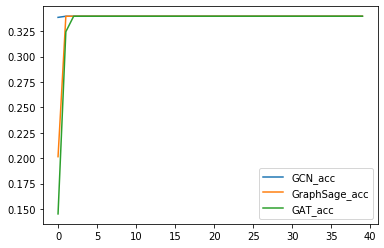

In [0]:
from matplotlib import pyplot as plt

plt.plot(GCN_acc ,label = "GCN_acc")
plt.plot(GraphSage_acc ,label = "GraphSage_acc")
plt.plot(GAT_acc ,label = "GAT_acc")
plt.legend()
#plt.show()
plt.savefig("output.png")